# Model Experiments

In [3]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets
import matplotlib.pyplot as plt

## Process data

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

DATA_DIR = "./data"
transformation = transforms.Compose([transforms.ToTensor()])

# mnist_real_train = datasets.FashionMNIST(DATA_DIR, train=True, download=False)
# mnist_real_test = datasets.FashionMNIST(DATA_DIR, train=False, download=False)
# mnist_real_test[0][0]

mnist_real_train = datasets.FashionMNIST(DATA_DIR, train=True, download=False, transform=transformation)
test_set = datasets.FashionMNIST(DATA_DIR, train=False, download=False, transform=transformation)

# mnist_real_train[0][0]
mnist_real_train[0][0].shape , len(mnist_real_train), len(test_set)





(torch.Size([1, 28, 28]), 60000, 10000)

### Splitting train into train and validation

In [5]:
train_set, validation_set = data.random_split(mnist_real_train, (50000, 10000))
len(train_set), len(validation_set)

(50000, 10000)

## Model

In [426]:
class ModelNoConv1Layer(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ModelNoConv1Layer, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, num_classes)
            # softmax built into cross entropy loss already
        )
    def forward(self, x):
        return self.network(x)
    

In [ ]:
class ModelNoConv(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ModelNoConv, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.ReLU(),   
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
            # softmax built into cross entropy loss already
        )
    def forward(self, x):
        return self.classifier(x)

In [6]:
class ModelNoConvDropout(nn.Module):
    def __init__(self, input_size, num_classes, dropout):
        super(ModelNoConvDropout, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(input_size, 512),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(dropout),
            nn.ReLU(),   
            nn.Linear(256, 128),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
            # softmax built into cross entropy loss already
        )
    def forward(self, x):
        return self.classifier(x)

In [755]:
train_set[0][0].shape, train_set

(torch.Size([1, 28, 28]), <torch.utils.data.dataset.Subset at 0x285f92540>)

In [7]:
# model = ModelNoConv1Layer(28*28, 10)
# model = ModelNoConv(784, 10)
model = ModelNoConvDropout(28*28, 10, 0.1)

In [8]:
learning_rate = 1e-4
weight_decay = 1e-4
normalisation = True
# if normalisation:
#     transforms.Compose()

In [9]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
batch_size = 64
num_epochs = 100

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)



In [11]:
len(train_loader), len(validation_loader), len(test_loader)

(782, 157, 157)

In [12]:

train_loss = []
validation_losses = []
validation_accuracy = []
test_accuracy = []
patience_counter = 0
window_size = 3
early_stopping_window = np.repeat(100, window_size)

for epoch in range(num_epochs):
    model.train()
    epoch_loss_total = 0 
    for (X_batch, y_batch) in train_loader:
        optimizer.zero_grad()
        loss = loss_func(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss_total += loss.detach()
    
    epoch_loss = epoch_loss_total / len(train_loader)
    print(f"Epoch: {epoch}/{num_epochs}, Train Loss: {loss}")
    train_loss.append(epoch_loss)
    

    # if epoch % 10 == 0:
    model.eval()
    right = 0
    total = 0
    validation_epoch_loss_total = 0

    with torch.no_grad():
        for (X_batch, y_batch) in validation_loader:    
            validation_epoch_loss_total += loss_func(model(X_batch), y_batch)
            
            total+=y_batch.size(0)
      
            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            right += (predicted==y_batch).sum().item()

    validation_epoch_loss = validation_epoch_loss_total/len(test_loader)
    validation_losses.append(validation_epoch_loss)    
    accuracy = right/total
    validation_accuracy.append(accuracy)
    
    # Early stopping
    patience = 3 # number of epochs to wait
    
    early_stopping_window = np.append(early_stopping_window,validation_epoch_loss)[1:]
    
    min_previous_validation_epoch_loss = early_stopping_window.min()
    print(f"Accuracy on Validation Set: {accuracy}, Validation Loss: {validation_epoch_loss}")
    if validation_epoch_loss <= min_previous_validation_epoch_loss:
        patience_counter = 0
    else:
        patience_counter += 1
        if (patience_counter == patience):
            print("Early stopping at epoch: ", epoch + 1)
            break    
    
    
  

    

Epoch: 0/100, Train Loss: 0.792698323726654
Accuracy on Validation Set: 0.7975, Validation Loss: 0.5672440528869629
Epoch: 1/100, Train Loss: 0.36505088210105896
Accuracy on Validation Set: 0.8332, Validation Loss: 0.4721466898918152
Epoch: 2/100, Train Loss: 0.3586246371269226
Accuracy on Validation Set: 0.8505, Validation Loss: 0.4282970130443573
Epoch: 3/100, Train Loss: 0.2768785357475281
Accuracy on Validation Set: 0.856, Validation Loss: 0.4006614089012146
Epoch: 4/100, Train Loss: 0.20334313809871674
Accuracy on Validation Set: 0.8634, Validation Loss: 0.377498060464859
Epoch: 5/100, Train Loss: 0.46088001132011414
Accuracy on Validation Set: 0.8744, Validation Loss: 0.35731250047683716
Epoch: 6/100, Train Loss: 0.4320516884326935
Accuracy on Validation Set: 0.8764, Validation Loss: 0.34754034876823425
Epoch: 7/100, Train Loss: 0.48275530338287354
Accuracy on Validation Set: 0.8783, Validation Loss: 0.3367135524749756
Epoch: 8/100, Train Loss: 0.48427799344062805
Accuracy on Val

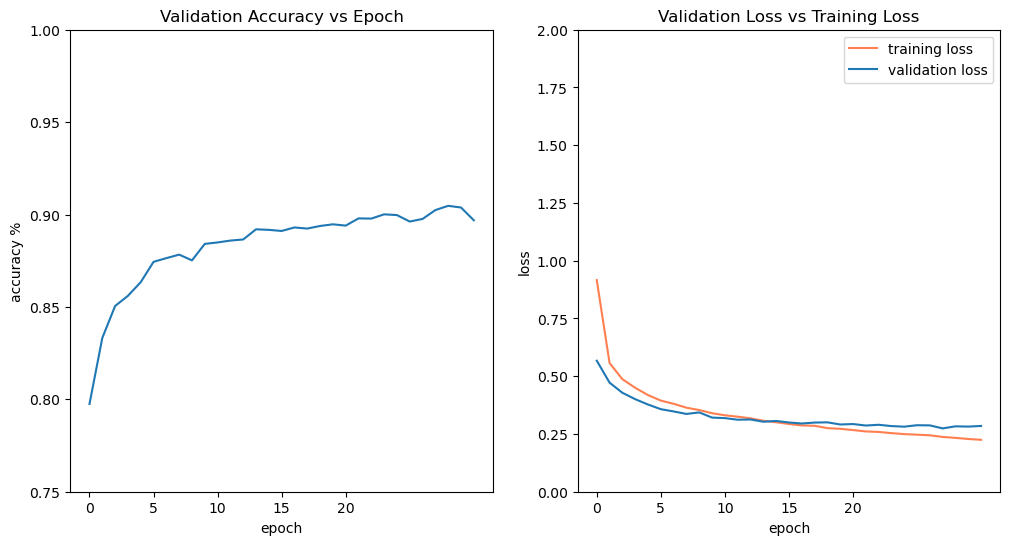

In [13]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 6))
axes[0].plot(validation_accuracy)
axes[1].plot(train_loss, color="coral", label="training loss")
axes[1].plot(validation_losses, label="validation loss")
axes[0].set_title("Validation Accuracy vs Epoch")
axes[1].set(ylim=(0, 2), xlabel="epoch", ylabel="loss")
axes[1].set_title("Validation Loss vs Training Loss")
axes[0].set(ylim=(0.75, 1), xticks=np.arange(0,21, 5), xlabel="epoch", ylabel="accuracy %")
axes[1].legend()
# axes[0].set_xticklabels(np.arange(0, num_epochs, num_epochs/(num_epochs * 0.1)), rotation="vertical")
# axes[1].set_xticklabels(np.arange(0, num_epochs, num_epochs/(num_epochs * 0.1)), rotation="vertical")

fig

In [14]:
total_correct = 0
total = 0
for (X_batch, y_batch) in test_loader:
    model.eval()
    total += y_batch.size()[0]
    output = model(X_batch)
    _, predicted = torch.max(output, 1)
    total_correct += (predicted == y_batch).sum().item()
    
test_accuracy = total_correct/total

print(f"Test Set Accuracy: {test_accuracy}")

Test Set Accuracy: 0.8903


Reading JPEGS

In [26]:
from torchvision import io as img_io
filepath = "./data/fashion-jpegs/bag.jpg"
img = img_io.read_image(filepath, mode=img_io.ImageReadMode.GRAY)
img = img.squeeze().float().unsqueeze(0)

output = model(img)
label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
_, predicted = torch.max(output, 1)
print("Classifier: ", label_map[predicted.item()])

Classifier:  Bag
